In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import os
from collections import namedtuple
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

from catch import Catch

from sith import SITH
from memory_hash import HashedMemory

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [109]:
"""
Reinforcement learning without going too deep.
"""

class SithSR(object):
    """SITH-based Successor Representation"""
    def __init__(self, state_len, action_len,
                 gamma=.9, alpha=.9, num_drifts=3,
                 info_rate=1./30., dt=1./30./10., dur=1./30./10.,
                 dtype=np.float32):
        # save the vars
        self._dtype = dtype
        self._state_len = state_len
        self._action_len = action_len
        self._info_rate = info_rate
        self._dt = dt
        self._dur = dur
        self._delay = info_rate - dt

        self._num_drifts = num_drifts

        self._gamma = gamma
        self._alpha = alpha

        self.history = None

        self._actions = torch.eye(action_len)

        # init sith
        self._in_sith = state_len + action_len
        self._sith = SITH(self._in_sith, dt=self._dt, ntau=25, dtype=self._dtype)
        self._p0 = torch.zeros((self._in_sith, 1))

        # allocate for M
        self._in_M = self._sith.T.size()[0]
        self._M = torch.zeros((self._in_sith, self._in_M)) # (outM, inM)

    def reset_T(self):
        self._sith.reset()

    def add_memory(self, reward):
        curr_history = torch.cat((self._sith.T.view(-1).unsqueeze(0),
                                  FloatTensor([reward]).unsqueeze(0)),
                                 1)
        if self.history is None:
            self.history = curr_history
        else:
            self.history = torch.cat((self.history, curr_history), 0)


    def _grab_goal(self, state):
        # Save current t for later
        t_save = self._sith._t.clone()

        # Pull out rewards and features from our history. They are needed
        # in seperate steps
        rewards = self.history[:,-1]
        rewarding = torch.zeros(self.history.size(0))
        historical_features = self.history[:, :-1]

        # Delay sith and find the reward values from the has table.
        for i in range(self._num_drifts):
            self._sith.update_t(item=None, dur=self._info_rate)
            feature_similarity = torch.mm(historical_features,
                                          self._sith.flatten_T().unsqueeze(1))
            # Take how closely related the historical features, and multiply
            # those by the rewards. This will tell use which history is the
            # closest to ours and the most rewarding.
            rewarding += feature_similarity.view(-1)*rewards

        # Return t to its previous
        self._sith._t = t_save
        self._sith._t_changed = True
        # Pull out the maximumly rewarding state of T from the hash table.
        # That is the goal for our actor
        out = self.history[rewarding.max(0)[1]][:,:-1]
        return out

    def pick_action(self, state):
        # try out various actions and get max reward
        goal_state = self._grab_goal(state)
        t_save = self._sith.t.clone()

        # try out each action
        potential_futures = None

        # we need to reset t to the old t every loop. &
        for a in self._actions:
            
            # update sith
            sa = torch.cat((state, a), 0)
            self._sith.update_t(sa, dur=self._dur)
            self._sith.update_t(item=None, dur=self._delay)

            # pass through M to get reward
            if potential_futures is None:
                potential_futures = self._M.mm(self._sith.T.view(-1, 1)).view(1, -1)
            else:
                potential_futures = torch.cat((potential_futures,
                                               self._M.mm(self._sith.T.view(-1, 1)).view(1, -1)),
                                              0)
            self._sith._t = t_save
            self._sith._t_changed = True

        evidence = potential_futures.mm(goal_state.view(-1, 1)[:self._in_sith])

        value, action_index = evidence.max(0)

        return action_index

    def learn_step(self, state, next_action):
        # turn into new sa1
        sa1 = torch.cat((state, self._actions[next_action].view(-1)), 0).unsqueeze(1)
        #print("SA1", sa1)
        sa1_p = torch.cat((torch.zeros((self._sith.T.size(0) - sa1.size(0), 1)), sa1), 0)
        #print("SA1_P", sa1_p)
        #print("M", self._M)
        # calc prediction from new state
        p1 = self._M.mm(sa1_p)
    
        #print("P1", p1)
        
        # update M based on prediction error
        perr = sa1 + self._gamma * p1 - self._p0
        #print(self._gamma, p1, p1*self._gamma)
        #print("PERR", perr)
        self._M += self._alpha * perr.mm(self._sith.T.view(1, -1))
        
        # update T with that state action
        self._sith.update_t(item=sa1.view(-1)*10., dur=self._dur)
        self._sith.update_t(item=None, dur=self._delay)

        # prepare for next loop
        #self._next_action = action
        self._p0 = p1


In [110]:

# global params
height = 10
width=10
num_actions = 3
input_size = width * height

# how many games to train on every frame
games_per_frame = 10

masks = [0] #[0, 1, 2, 4, 8, 12, 16]

q_sizes = {'RL':[1]}
           #'queue': [1, 5, 10]}
mod_type = ["RL"]
num_runs = 1
model = SithSR(state_len=input_size, action_len=num_actions)

run_base = 'catch_long_lr'
#run_base = 'catch_MSE'
num_games = 1000
hidden_size = input_size * 1
per_random_act = .1
# set up the catch environment
c = Catch(screen_height=height, screen_width=width,
          game_over_conditions = {'ball_deletions': 1},
          mask=0, ball_spawn_rate=height+1,)

In [111]:
tot_score = 0.0

# train over total epochs
for e in range(num_games):
    c.reset()
    model.reset_T()
    game_over = False
    # get initial input
    input_t = Tensor(c.observe(flatten=True))
    
    #iterate over each game
    while not game_over:
        # t_-1 is the previous observation
        input_tm1 = input_t.clone()


        # Randomly pick an action, or use the
        # Previously calculated action
        if (np.random.rand() <= per_random_act) or (model.history is None):
            action = (torch.rand(1) * (num_actions)).type(LongTensor)
        else:
            action = model.pick_action(input_tm1)

        # apply action, get rewards and new state
        reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

        # t_0, current timestep
        input_t = Tensor(c.observe(flatten=True))

        # store experience
        model.learn_step(input_tm1, action)
        if reward != 0:
            model.add_memory(reward)
            tot_score += reward
    print(e, ": ", tot_score)
    # Reset Game and Model Queue when the game is over.
    

0 :  1.0
1 :  2.0
2 :  1.0
3 :  0.0
4 :  1.0
5 :  0.0
6 :  -1.0
7 :  -2.0
8 :  -1.0
9 :  0.0
10 :  -1.0
11 :  -2.0
12 :  -3.0
13 :  -4.0
14 :  -3.0
15 :  -2.0
16 :  -3.0
17 :  -2.0
18 :  -1.0
19 :  -2.0
20 :  -3.0
21 :  -2.0
22 :  -3.0
23 :  -4.0
24 :  -5.0
25 :  -6.0
26 :  -7.0
27 :  -8.0
28 :  -9.0
29 :  -10.0
30 :  -11.0
31 :  -12.0
32 :  -11.0
33 :  -10.0
34 :  -11.0
35 :  -10.0
36 :  -11.0
37 :  -12.0
38 :  -13.0
39 :  -12.0
40 :  -13.0
41 :  -14.0
42 :  -15.0
43 :  -16.0
44 :  -15.0
45 :  -16.0
46 :  -15.0
47 :  -16.0
48 :  -17.0
49 :  -18.0
50 :  -19.0
51 :  -18.0
52 :  -17.0
53 :  -16.0
54 :  -17.0
55 :  -18.0
56 :  -19.0
57 :  -18.0
58 :  -19.0
59 :  -20.0
60 :  -21.0
61 :  -22.0
62 :  -23.0
63 :  -24.0
64 :  -23.0
65 :  -24.0
66 :  -25.0
67 :  -24.0
68 :  -23.0
69 :  -22.0
70 :  -21.0
71 :  -22.0
72 :  -21.0
73 :  -22.0
74 :  -21.0
75 :  -22.0
76 :  -23.0
77 :  -24.0
78 :  -25.0
79 :  -26.0
80 :  -27.0
81 :  -26.0
82 :  -27.0
83 :  -28.0
84 :  -27.0
85 :  -26.0
86 :  -25.0
87

629 :  -248.0
630 :  -247.0
631 :  -246.0
632 :  -245.0
633 :  -246.0
634 :  -247.0
635 :  -248.0
636 :  -247.0
637 :  -246.0
638 :  -247.0
639 :  -248.0
640 :  -249.0
641 :  -250.0
642 :  -251.0
643 :  -250.0
644 :  -249.0
645 :  -248.0
646 :  -249.0
647 :  -250.0
648 :  -249.0
649 :  -248.0
650 :  -249.0
651 :  -250.0
652 :  -251.0
653 :  -252.0
654 :  -253.0
655 :  -254.0
656 :  -255.0
657 :  -256.0
658 :  -255.0
659 :  -256.0
660 :  -257.0
661 :  -256.0
662 :  -257.0
663 :  -256.0
664 :  -257.0
665 :  -258.0
666 :  -259.0
667 :  -260.0
668 :  -261.0
669 :  -262.0
670 :  -261.0
671 :  -262.0
672 :  -263.0
673 :  -264.0
674 :  -263.0
675 :  -264.0
676 :  -265.0
677 :  -266.0
678 :  -265.0
679 :  -266.0
680 :  -265.0
681 :  -266.0
682 :  -267.0
683 :  -268.0
684 :  -269.0
685 :  -270.0
686 :  -269.0
687 :  -268.0
688 :  -269.0
689 :  -268.0
690 :  -269.0
691 :  -270.0
692 :  -271.0
693 :  -272.0
694 :  -271.0
695 :  -270.0
696 :  -271.0
697 :  -272.0
698 :  -273.0
699 :  -274.0
700 : 

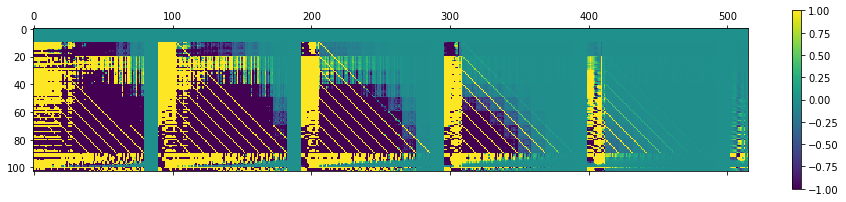

In [112]:
matshow(model._M.clamp(-1,1).numpy())
colorbar()


In [113]:
model._M.max()

516630.84375

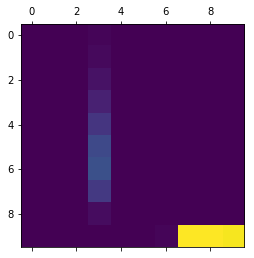

In [70]:
matshow(model._sith.T[0:100].view(10,10).numpy())

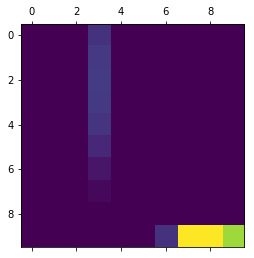

In [78]:
matshow(model._sith.T[103:203].view(10,10).numpy())

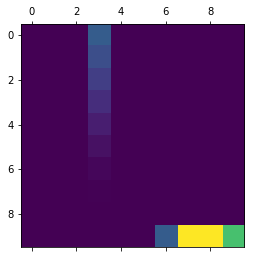

In [79]:
matshow(model._sith.T[206:306].view(10,10).numpy())

In [ ]:
matshow(model._sith.T[0:100].view(10,10).numpy())

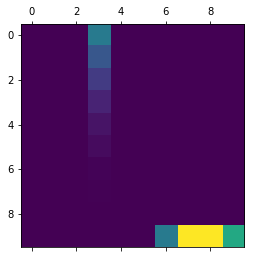

In [77]:
matshow(model._sith.T[-103:-3].view(10,10).numpy())